In [ ]:
pip install alpaca-py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 5.3 MB/s eta 0:00:00


In [ ]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
import pandas as pd
from datetime import datetime
import os
import time

In [ ]:
API_KEY = "INSERIRE_ALPACA_APY_KEY"
SECRET_KEY = "INSERIRE_ALPACA_SECRET_KEY"
client = StockHistoricalDataClient(API_KEY, SECRET_KEY)

In [ ]:
symbol = "QQQ"
timeframe = TimeFrame.Minute

# Anni da scaricare
anni = [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

for year in anni:
    print(f"Scarico dati per: {year}")

    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)

    params = StockBarsRequest(
        symbol_or_symbols=symbol,
        timeframe=timeframe,
        start=start_date,
        end=end_date
    )

    try:
        bars = client.get_stock_bars(params)
        df = bars.df

        if not df.empty:
            filename = f"qqq_{year}.csv"
            df.to_csv(filename)
            print(f"Salvato: {filename}")
        else:
            print(f"Nessun dato per {year}")

    except Exception as e:
        print(f"Errore nel download di {year}: {e}")

    # Pausa tra le richieste per evitare blocchi
    time.sleep(5)

Scarico dati per: 2016
Salvato: qqq_2016.csv
Scarico dati per: 2017
Salvato: qqq_2017.csv
Scarico dati per: 2018
Salvato: qqq_2018.csv
Scarico dati per: 2019
Salvato: qqq_2019.csv
Scarico dati per: 2020
Salvato: qqq_2020.csv
Scarico dati per: 2021
Salvato: qqq_2021.csv
Scarico dati per: 2022
Salvato: qqq_2022.csv
Scarico dati per: 2023
Salvato: qqq_2023.csv
Scarico dati per: 2024
Salvato: qqq_2024.csv


In [ ]:
import glob

In [ ]:
# Trova tutti i file che iniziano con "qqq_" e finiscono con ".csv"
file_list = sorted(glob.glob("qqq_*.csv"))

# Carica e concatena tutto
df_list = [pd.read_csv(f) for f in file_list]
df_all = pd.concat(df_list)

# Salva il file unificato
df_all.to_csv("qqq_1min_full.csv", index=False)
print("Tutti i file uniti in: qqq_1min_full.csv")

Tutti i file uniti in: qqq_1min_full.csv


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def calculate_cagr(start_val, end_val, periods_in_years):
    return (end_val / start_val) ** (1 / periods_in_years) - 1

def calculate_volatility(series):
    return series.pct_change().std() * np.sqrt(252)

def calculate_max_drawdown(equity_curve):
    peak = equity_curve.cummax()
    drawdown = (equity_curve - peak) / peak
    return drawdown.min()

def calculate_sharpe(series):
    returns = series.pct_change()
    return (returns.mean() / returns.std()) * np.sqrt(252)

def calculate_sortino(series):
    returns = series.pct_change()
    downside = returns[returns < 0]
    downside_std = downside.std() * np.sqrt(252)
    expected_return = returns.mean() * 252
    return expected_return / downside_std if downside_std != 0 else np.nan

In [ ]:
df = pd.read_csv("qqq_1min_full.csv", parse_dates=['timestamp'])
df.set_index('timestamp', inplace=True)

# Converte da UTC a US/Eastern correttamente
df.index = df.index.tz_convert("US/Eastern")

# Filtra orari mercato reale
df = df.between_time("09:30", "16:00")

# Inizializza parametri
df['date'] = df.index.date
results = []
account_value = 25000
max_leverage = 4
commission_per_share = 0.0005

for date, group in df.groupby('date'):
    if len(group) < 80:
        continue

    day = group.copy()

    # Crea candele 5 minuti
    candles = day.resample("5min").agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }).dropna()

    if len(candles) < 2:
        continue

    c1 = candles.iloc[0]  # prima candela 09:30–09:35
    c2 = candles.iloc[1]  # seconda candela 09:35–09:40

    # Salta se è un doji
    if round(c1.open, 2) == round(c1.close, 2):
        continue

    direction = "long" if c1.close > c1.open else "short"
    entry_price = c2.open
    stop = c1.low if direction == "long" else c1.high
    R = abs(entry_price - stop)

    # ✅ Salta se R troppo piccolo (es. < 5 cent)
    if R == 0 or R < 0.05:
        continue

    risk_per_trade = 0.01 * account_value
    max_position = max_leverage * account_value / entry_price
    shares = min(risk_per_trade / R, max_position)
    shares = int(shares)

    if shares == 0:
        continue

    trade = candles.iloc[2:]
    exit_price = None
    hit_target = False

    for _, row in trade.iterrows():
        high = row.high
        low = row.low

        if direction == "long":
            if low <= stop:
                exit_price = stop
                break
            if high >= entry_price + 10 * R:
                exit_price = entry_price + 10 * R
                hit_target = True
                break
        else:
            if high >= stop:
                exit_price = stop
                break
            if low <= entry_price - 10 * R:
                exit_price = entry_price - 10 * R
                hit_target = True
                break

    if exit_price is None:
        exit_price = candles.iloc[-1].close  # EoD exit

    pnl_per_share = exit_price - entry_price if direction == "long" else entry_price - exit_price
    pnl_total = shares * pnl_per_share
    cost = shares * commission_per_share * 2
    net_pnl = pnl_total - cost

    results.append({
        'date': date,
        'direction': direction,
        'entry': entry_price,
        'exit': exit_price,
        'shares': shares,
        'R': R,
        'PnL_$': net_pnl,
        'PnL_R': net_pnl / risk_per_trade
    })

# Risultati
res_df = pd.DataFrame(results)
res_df['cum_pnl'] = res_df['PnL_$'].cumsum()

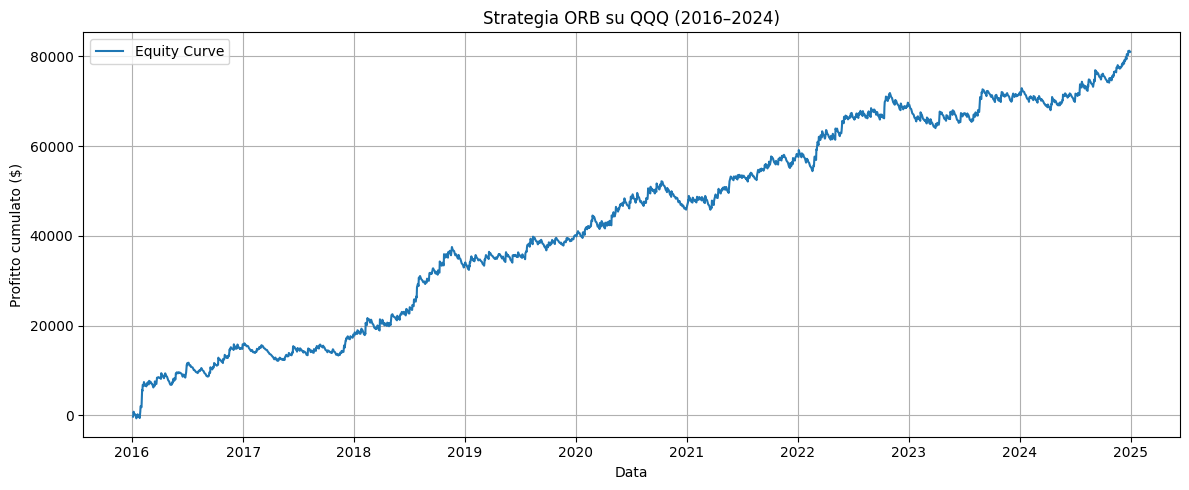

Risultati Backtest ORB su QQQ:
Totale trade: 2216
Win rate: 24.55%
Sharpe (approssimato): 1.26
Rendimento totale: $81004.83


In [ ]:
# Equity curve
plt.figure(figsize=(12, 5))
plt.plot(res_df['date'], res_df['cum_pnl'], label='Equity Curve')
plt.xlabel("Data")
plt.ylabel("Profitto cumulato ($)")
plt.title("Strategia ORB su QQQ (2016–2024)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Statistiche
print("Risultati Backtest ORB su QQQ:")
print(f"Totale trade: {len(res_df)}")
print(f"Win rate: {round((res_df['PnL_R'] > 0).mean() * 100, 2)}%")
print(f"Sharpe (approssimato): {round(res_df['PnL_$'].mean() / res_df['PnL_$'].std() * (252**0.5), 2)}")
print(f"Rendimento totale: ${round(res_df['cum_pnl'].iloc[-1], 2)}")

In [ ]:
# --- Strategia BUY & HOLD su QQQ (passiva) ---

# Prendiamo la prima e l’ultima riga valide del dataset filtrato
df_buyhold = df.copy()
df_buyhold['date'] = df_buyhold.index.date
daily_close = df_buyhold.groupby('date')['close'].last()

start_price = daily_close.iloc[0]
end_price = daily_close.iloc[-1]
capital = 25000
shares_held = capital / start_price
final_value = shares_held * end_price


In [ ]:
# Equity curve buy&hold
buyhold_equity = daily_close * shares_held
buyhold_equity = buyhold_equity - capital  # mostra profitto netto come ORB

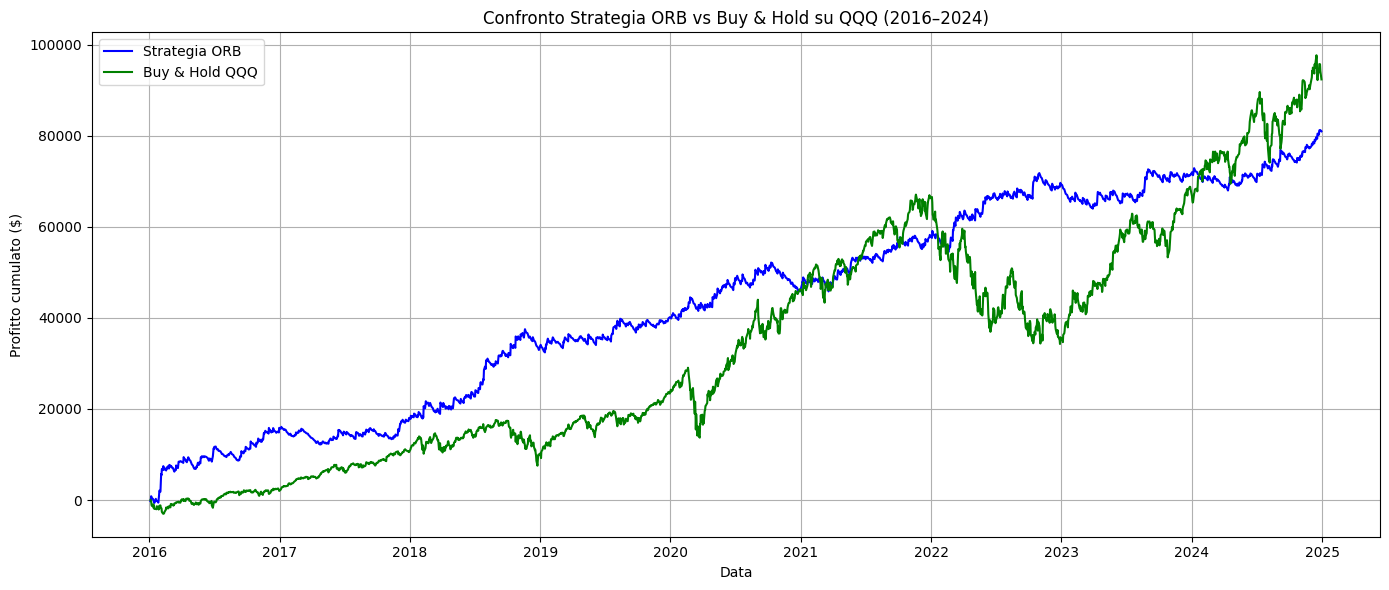

Confronto Attivo vs Passivo:
Strategia ORB:    $81004.83
Buy & Hold QQQ:   $92410.63


In [ ]:
# Aggiungiamo ORB curve per confronto
plt.figure(figsize=(14, 6))
plt.plot(res_df['date'], res_df['cum_pnl'], label='Strategia ORB', color='blue')
plt.plot(buyhold_equity.index, buyhold_equity.values, label='Buy & Hold QQQ', color='green')
plt.xlabel("Data")
plt.ylabel("Profitto cumulato ($)")
plt.title("Confronto Strategia ORB vs Buy & Hold su QQQ (2016–2024)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

# Stampa risultati comparativi
print("Confronto Attivo vs Passivo:")
print(f"Strategia ORB:    ${round(res_df['cum_pnl'].iloc[-1], 2)}")
print(f"Buy & Hold QQQ:   ${round(final_value - capital, 2)}")

In [ ]:
import numpy as np

In [ ]:
# Equity curve in valore totale (non solo profitti)
orb_equity = res_df['cum_pnl'] + capital
buyhold_equity_full = buyhold_equity + capital

# Anni di investimento
years = (daily_close.index[-1] - daily_close.index[0]).days / 365.25

# --- METRICHE ORB ---
orb_cagr = calculate_cagr(capital, orb_equity.iloc[-1], years)
orb_vol = calculate_volatility(orb_equity)
orb_dd = calculate_max_drawdown(orb_equity)
orb_sharpe = calculate_sharpe(orb_equity)
orb_sortino = calculate_sortino(orb_equity)

# --- METRICHE BUY & HOLD ---
bh_cagr = calculate_cagr(capital, buyhold_equity_full.iloc[-1], years)
bh_vol = calculate_volatility(buyhold_equity_full)
bh_dd = calculate_max_drawdown(buyhold_equity_full)
bh_sharpe = calculate_sharpe(buyhold_equity_full)
bh_sortino = calculate_sortino(buyhold_equity_full)

# --- STAMPA METRICHE CONFRONTO ---
print("\n Metriche comparative ORB vs Buy & Hold:")
print("Strategia ORB:")
print(f" - Rendimento annualizzato (CAGR): {orb_cagr:.2%}")
print(f" - Volatilità annualizzata: {orb_vol:.2%}")
print(f" - Max Drawdown: {orb_dd:.2%}")
print(f" - Sharpe Ratio: {orb_sharpe:.2f}")
print(f" - Sortino Ratio: {orb_sortino:.2f}")

print("\nStrategia Buy & Hold:")
print(f" - Rendimento annualizzato (CAGR): {bh_cagr:.2%}")
print(f" - Volatilità annualizzata: {bh_vol:.2%}")
print(f" - Max Drawdown: {bh_dd:.2%}")
print(f" - Sharpe Ratio: {bh_sharpe:.2f}")
print(f" - Sortino Ratio: {bh_sortino:.2f}")


 Metriche comparative ORB vs Buy & Hold:
Strategia ORB:
 - Rendimento annualizzato (CAGR): 17.44%
 - Volatilità annualizzata: 12.74%
 - Max Drawdown: -9.46%
 - Sharpe Ratio: 1.36
 - Sortino Ratio: 7.86

Strategia Buy & Hold:
 - Rendimento annualizzato (CAGR): 18.78%
 - Volatilità annualizzata: 21.86%
 - Max Drawdown: -35.64%
 - Sharpe Ratio: 0.90
 - Sortino Ratio: 1.15
